In [1]:
import sklearn.utils

def check_matplotlib_support(caller_name):
    try:
        import matplotlib
    except ImportError:
        raise ImportError(
            "Matplotlib is required for plotting functions in " + caller_name
        )

setattr(sklearn.utils, 'check_matplotlib_support', check_matplotlib_support)

In [37]:
from sklift.datasets import fetch_x5
from feature_extraction import UpliftFeatureExtractor
import gc
from model_extraction import *
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklift.models import TwoModels
from sklift.metrics import uplift_auc_score, qini_auc_score
import matplotlib.pyplot as plt

from sklift.metrics import (
    uplift_auc_score,
    qini_auc_score,
    uplift_at_k,
    weighted_average_uplift,
)

In [3]:
dataset = fetch_x5()
data = dataset.data

In [ ]:
# подсчет фич
extractor = UpliftFeatureExtractor(drop_redundant=True)
df = extractor.calculate_features(
    clients_df=data.clients,
    train_df=data.train,
    treatment_df=dataset.treatment,
    target_df=dataset.target,
    purchases_df=data.purchases
)

del data
gc.collect()

features = extractor.feature_names

print(f"Создано признаков: {len(features)}")
print(f"Размер датафрейма: {df.shape}")
print(f"Признаки: {features}")

Создано признаков: 32
Размер датафрейма: (200039, 34)
Признаки: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'gender', 'is_activated']


In [5]:
TARGET_COL = "target"
TREATMENT_COL = "treatment_flg"

y = df[TARGET_COL].values
t = df[TREATMENT_COL].values
X_all = df[features].copy()

# стратификация по (treatment, target)
strata = df[[TREATMENT_COL, TARGET_COL]].astype(str).agg("_".join, axis=1)

# единый сплит для всех трёх лёрнеров
X_train_base, X_test_base, y_train, y_test, t_train, t_test = train_test_split(
    X_all,
    y,
    t,
    test_size=0.3,
    random_state=42,
    stratify=strata,
)

# колонки для T-learner (логрег)
num_cols = X_train_base.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train_base.select_dtypes(include=["object"]).columns.tolist()

# данные для S-learner (CatBoost)
X_train_s = X_train_base.copy()
X_test_s = X_test_base.copy()

X_train_s[TREATMENT_COL] = t_train
X_test_s[TREATMENT_COL] = t_test

cat_cols_s = X_train_s.select_dtypes(include=["object", "category"]).columns
cat_features_s = list(cat_cols_s)

# для X-learner и baseline (X_train_base)
cat_cols_base = X_train_base.select_dtypes(include=["object", "category"]).columns
cat_features_base = list(cat_cols_base)

In [6]:
# T-learner (логрег + скейл + OHE)
t_model = build_t_learner_logreg(num_cols=num_cols, cat_cols=cat_cols)
t_model.fit(X_train_base, y_train, treatment=t_train)
uplift_t = t_model.predict(X_test_base)

# S-learner (CatBoost)
s_model = build_s_learner_catboost(cat_features=cat_features_s)
s_model.fit(
    X_train_s,
    y_train,
    eval_set=(X_test_s, y_test),
)
uplift_s = predict_uplift_s_learner(
    s_model,
    X_test_s,
    treatment_col=TREATMENT_COL,
)

# X-learner (CatBoost + MyXLearner)
x_model = build_x_learner_catboost(cat_features=cat_features_base)
x_model.fit(X_train_base, y_train, treatment=t_train)
uplift_x = x_model.predict(X_test_base)

0:	test: 0.7484492	best: 0.7484492 (0)	total: 212ms	remaining: 3m 31s
1:	test: 0.7529384	best: 0.7529384 (1)	total: 308ms	remaining: 2m 33s
2:	test: 0.7575475	best: 0.7575475 (2)	total: 399ms	remaining: 2m 12s
3:	test: 0.7580720	best: 0.7580720 (3)	total: 498ms	remaining: 2m 4s
4:	test: 0.7587389	best: 0.7587389 (4)	total: 596ms	remaining: 1m 58s
5:	test: 0.7601256	best: 0.7601256 (5)	total: 689ms	remaining: 1m 54s
6:	test: 0.7605767	best: 0.7605767 (6)	total: 780ms	remaining: 1m 50s
7:	test: 0.7609700	best: 0.7609700 (7)	total: 886ms	remaining: 1m 49s
8:	test: 0.7611235	best: 0.7611235 (8)	total: 979ms	remaining: 1m 47s
9:	test: 0.7617066	best: 0.7617066 (9)	total: 1.08s	remaining: 1m 46s
10:	test: 0.7620303	best: 0.7620303 (10)	total: 1.19s	remaining: 1m 46s
11:	test: 0.7623239	best: 0.7623239 (11)	total: 1.29s	remaining: 1m 46s
12:	test: 0.7624114	best: 0.7624114 (12)	total: 1.39s	remaining: 1m 45s
13:	test: 0.7626959	best: 0.7626959 (13)	total: 1.48s	remaining: 1m 44s
14:	test: 0.7

In [7]:
baseline_model = build_baseline_catboost(cat_features=cat_features_base)
baseline_model.fit(
    X_train_base,
    y_train,
    eval_set=(X_test_base, y_test),
)
baseline_score = baseline_model.predict_proba(X_test_base)[:, 1]

0:	test: 0.7482522	best: 0.7482522 (0)	total: 117ms	remaining: 1m 56s
1:	test: 0.7551396	best: 0.7551396 (1)	total: 228ms	remaining: 1m 53s
2:	test: 0.7566162	best: 0.7566162 (2)	total: 322ms	remaining: 1m 46s
3:	test: 0.7578633	best: 0.7578633 (3)	total: 428ms	remaining: 1m 46s
4:	test: 0.7583197	best: 0.7583197 (4)	total: 529ms	remaining: 1m 45s
5:	test: 0.7593697	best: 0.7593697 (5)	total: 636ms	remaining: 1m 45s
6:	test: 0.7603338	best: 0.7603338 (6)	total: 741ms	remaining: 1m 45s
7:	test: 0.7607133	best: 0.7607133 (7)	total: 844ms	remaining: 1m 44s
8:	test: 0.7614508	best: 0.7614508 (8)	total: 942ms	remaining: 1m 43s
9:	test: 0.7615222	best: 0.7615222 (9)	total: 1.05s	remaining: 1m 43s
10:	test: 0.7618225	best: 0.7618225 (10)	total: 1.14s	remaining: 1m 42s
11:	test: 0.7618454	best: 0.7618454 (11)	total: 1.25s	remaining: 1m 42s
12:	test: 0.7620472	best: 0.7620472 (12)	total: 1.35s	remaining: 1m 42s
13:	test: 0.7622832	best: 0.7622832 (13)	total: 1.45s	remaining: 1m 42s
14:	test: 0.

In [8]:
# 1. Сводка uplift-метрик по моделям

def compute_uplift_metrics(y_true, uplift_score, treatment, prefix=""):
    res = {}
    res[f"{prefix}AUUC"] = uplift_auc_score(y_true, uplift_score, treatment)
    res[f"{prefix}Qini"] = qini_auc_score(y_true, uplift_score, treatment)
    res[f"{prefix}WAU"] = weighted_average_uplift(y_true, uplift_score, treatment)

    for k in (0.1, 0.2, 0.3, 0.5):
        res[f"{prefix}Uplift@{int(k*100)}%"] = uplift_at_k(
            y_true=y_true,
            uplift=uplift_score,
            treatment=treatment,
            strategy="overall",
            k=k,
        )
    return res


metrics = {}

metrics["T-learner_logreg"] = compute_uplift_metrics(
    y_test, uplift_t, t_test
)
metrics["S-learner_catboost"] = compute_uplift_metrics(
    y_test, uplift_s, t_test
)
metrics["X-learner_catboost"] = compute_uplift_metrics(
    y_test, uplift_x, t_test
)
metrics["Baseline_catboost"] = compute_uplift_metrics(
    y_test, baseline_score, t_test
)

metrics_df = (
    pd.DataFrame(metrics)
    .T
    .rename_axis("model")
    .reset_index()
)

print("Сводная таблица uplift-метрик")
display(metrics_df)

Сводная таблица uplift-метрик


,model,AUUC,Qini,WAU,Uplift@10%,Uplift@20%,Uplift@30%,Uplift@50%
0,T-learner_logreg,0.019362,0.012652,0.033523,0.108821,0.071711,0.057899,0.047868
1,S-learner_catboost,0.019331,0.012600,0.033832,0.109142,0.070292,0.060671,0.042996
2,X-learner_catboost,0.019131,0.012551,0.033913,0.113861,0.070917,0.059912,0.044960
3,Baseline_catboost,-0.010568,-0.006811,0.032570,0.000374,0.010743,0.016740,0.024410


<Figure size 1200x600 with 0 Axes>

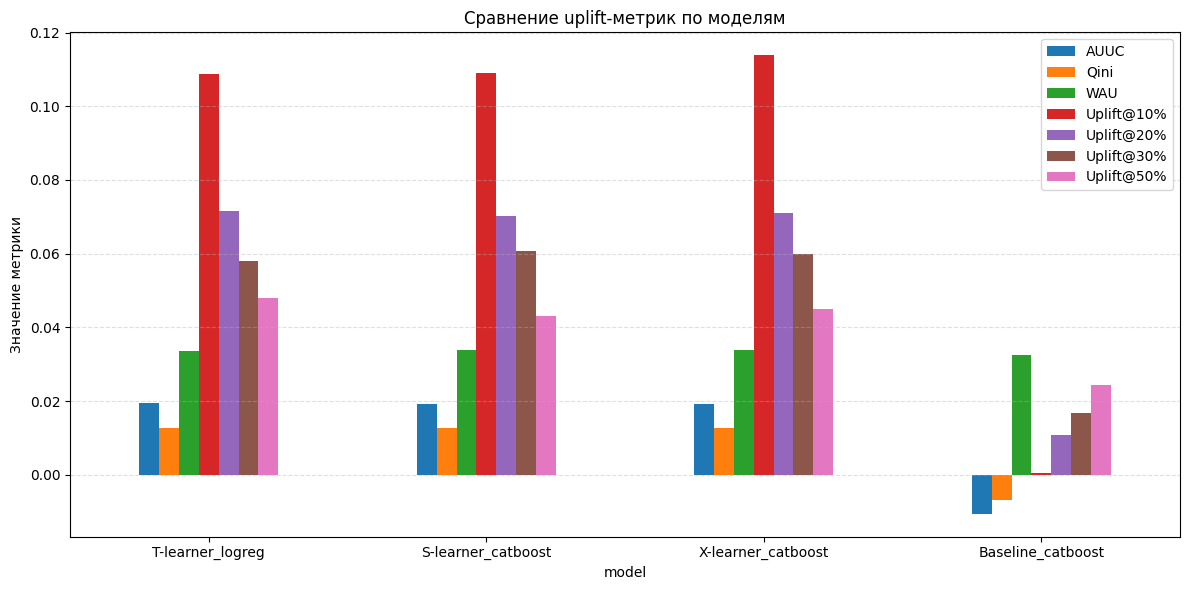

In [9]:
metric_cols = [
    "AUUC",
    "Qini",
    "WAU",
    "Uplift@10%",
    "Uplift@20%",
    "Uplift@30%",
    "Uplift@50%",
]
metrics_for_plot = metrics_df.set_index("model")[metric_cols]

plt.figure(figsize=(12, 6))
metrics_for_plot.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Значение метрики")
plt.title("Сравнение uplift-метрик по моделям")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Sklift старый, поэтому по какой-то причине графики на кривые не работают или работают криво, используем свои функции:

In [34]:

def compute_qini_curve(y_true, uplift, treatment):
    df = pd.DataFrame({
        "y": y_true,
        "uplift": uplift,
        "t": treatment,
    })

    # сортировка по убыванию uplift
    df = df.sort_values("uplift", ascending=False).reset_index(drop=True)

    df["treated"] = (df["t"] == 1).astype(int)
    df["control"] = (df["t"] == 0).astype(int)

    n_t = df["treated"].sum()
    n_c = df["control"].sum()

    # приросты
    df["gain_t"] = df["treated"] * df["y"]
    df["gain_c"] = df["control"] * df["y"] * (n_t / n_c)

    # кумулятивные суммы
    df["cum_t"] = df["gain_t"].cumsum()
    df["cum_c"] = df["gain_c"].cumsum()

    # Qini-кривая
    qini = df["cum_t"] - df["cum_c"]

    # доля выборки
    x = (np.arange(len(df)) + 1) / len(df)

    return x, qini.values


def compute_uplift_curve(y_true, uplift, treatment):
    df = pd.DataFrame({
        "y": y_true,
        "uplift": uplift,
        "t": treatment,
    })

    df = df.sort_values("uplift", ascending=False).reset_index(drop=True)

    df["treated"] = (df["t"] == 1).astype(int)
    df["control"] = (df["t"] == 0).astype(int)

    df["y_t"] = df["y"] * df["treated"]
    df["y_c"] = df["y"] * df["control"]

    df["cum_y_t"] = df["y_t"].cumsum()
    df["cum_y_c"] = df["y_c"].cumsum()
    df["cum_t"] = df["treated"].cumsum()
    df["cum_c"] = df["control"].cumsum()

    p_t = df["cum_y_t"] / df["cum_t"].replace(0, np.nan)
    p_c = df["cum_y_c"] / df["cum_c"].replace(0, np.nan)

    uplift_curve = p_t - p_c
    # без FutureWarning: нормальное заполнение пропусков
    uplift_curve = uplift_curve.ffill().bfill().fillna(0)

    x = (np.arange(len(df)) + 1) / len(df)

    return x, uplift_curve.values


def plot_qini(y_true, uplift, treatment, label):
    x, q = compute_qini_curve(y_true, uplift, treatment)
    auc_q = qini_auc_score(y_true, uplift, treatment)
    plt.plot(x, q, label=f"{label} (Qini AUC={auc_q:.3f})")


def plot_uplift(y_true, uplift, treatment, label):
    x, u = compute_uplift_curve(y_true, uplift, treatment)
    auc_u = uplift_auc_score(y_true, uplift, treatment)
    plt.plot(x, u, label=f"{label} (AUUC={auc_u:.3f})")

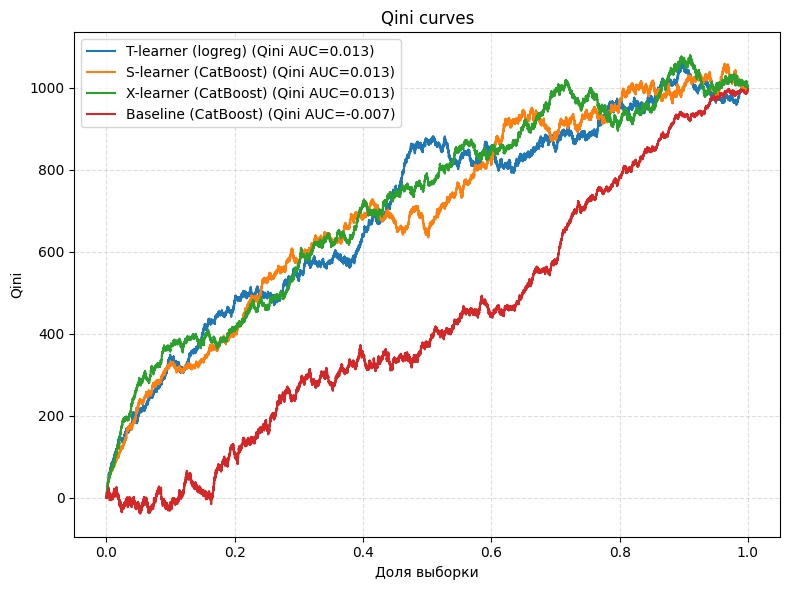

In [35]:
plt.figure(figsize=(8, 6))

plot_qini(y_test, uplift_t, t_test, "T-learner (logreg)")
plot_qini(y_test, uplift_s, t_test, "S-learner (CatBoost)")
plot_qini(y_test, uplift_x, t_test, "X-learner (CatBoost)")
plot_qini(y_test, baseline_score, t_test, "Baseline (CatBoost)")

plt.title("Qini curves")
plt.xlabel("Доля выборки")
plt.ylabel("Qini")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

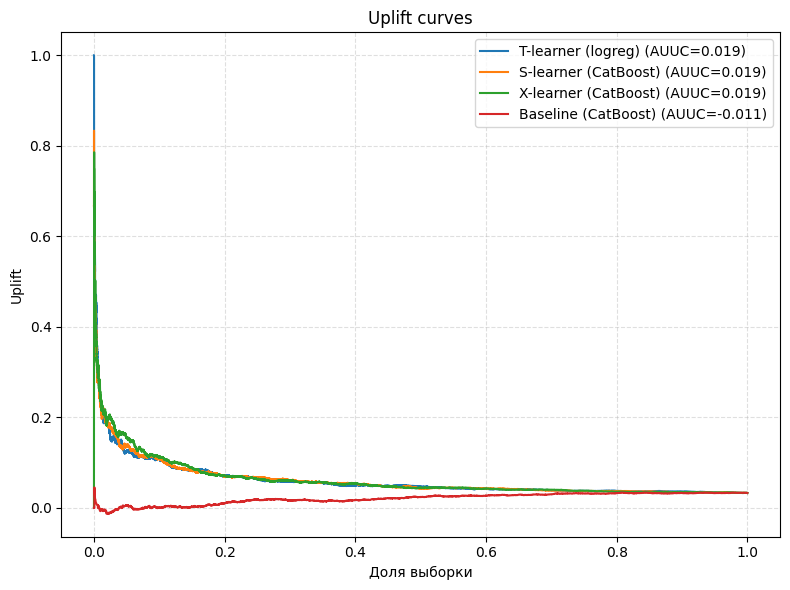

In [36]:
plt.figure(figsize=(8, 6))

plot_uplift(y_test, uplift_t, t_test, "T-learner (logreg)")
plot_uplift(y_test, uplift_s, t_test, "S-learner (CatBoost)")
plot_uplift(y_test, uplift_x, t_test, "X-learner (CatBoost)")
plot_uplift(y_test, baseline_score, t_test, "Baseline (CatBoost)")

plt.title("Uplift curves")
plt.xlabel("Доля выборки")
plt.ylabel("Uplift")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Важность для T-learner (логрег) через uplift-коэффициенты
def get_t_logreg_uplift_importance_by_feature(t_model):
    pipe_trmnt = t_model.estimator_trmnt
    pipe_ctrl = t_model.estimator_ctrl

    pre_tr = pipe_trmnt.named_steps["preprocess"]
    clf_t = pipe_trmnt.named_steps["clf"]
    clf_c = pipe_ctrl.named_steps["clf"]

    feature_names = pre_tr.get_feature_names_out()
    beta_t = clf_t.coef_.ravel()
    beta_c = clf_c.coef_.ravel()
    beta_u = beta_t - beta_c  # uplift-эффект по признаку

    imp = {}
    for name, coef in zip(feature_names, beta_u):
        # num__age -> age
        if name.startswith("num__"):
            base = name.split("num__", 1)[1]
        elif name.startswith("cat__"):
            # cat__gender_M -> gender
            tmp = name.split("cat__", 1)[1]
            if "_" in tmp:
                base = tmp.rsplit("_", 1)[0]
            else:
                base = tmp
        else:
            base = name

        val = abs(coef)
        imp[base] = imp.get(base, 0.0) + val

    return imp


t_importance = get_t_logreg_uplift_importance_by_feature(t_model)


# Общий хелпер для CatBoost feature_importance

def get_catboost_importance(model, feature_names):
    fi = model.get_feature_importance()
    return {name: float(val) for name, val in zip(feature_names, fi)}


# Важность для S-learner (CatBoost)
s_importance = get_catboost_importance(s_model, X_train_s.columns)

# Важность для X-learner
# берём importance из tau_0 и tau_1 и усредняем
fi_tau0 = x_model.model_tau_0.get_feature_importance()
fi_tau1 = x_model.model_tau_1.get_feature_importance()
fi_tau_mean = (fi_tau0 + fi_tau1) / 2.0

x_importance = {
    name: float(val)
    for name, val in zip(X_train_base.columns, fi_tau_mean)
}

# Важность для baseline CatBoost
baseline_importance = get_catboost_importance(baseline_model, X_train_base.columns)


# Сводная таблица важности по всем моделям

# соберём полный список фич
all_features = sorted(
    set(t_importance.keys())
    | set(s_importance.keys())
    | set(x_importance.keys())
    | set(baseline_importance.keys())
)

imp_df = pd.DataFrame(
    index=all_features,
    columns=[
        "T_logreg_uplift",
        "S_catboost",
        "X_effect_catboost",
        "Baseline_catboost",
    ],
    dtype=float,
)

for f in all_features:
    imp_df.loc[f, "T_logreg_uplift"] = t_importance.get(f, 0.0)
    imp_df.loc[f, "S_catboost"] = s_importance.get(f, 0.0)
    imp_df.loc[f, "X_effect_catboost"] = x_importance.get(f, 0.0)
    imp_df.loc[f, "Baseline_catboost"] = baseline_importance.get(f, 0.0)

# нормируем по каждой модели
for col in imp_df.columns:
    s = imp_df[col].sum()
    if s > 0:
        imp_df[col] = imp_df[col] / s

# средняя uplift-важность по моделям
imp_df["mean_uplift_importance"] = imp_df.mean(axis=1)

imp_df_sorted = imp_df.sort_values("mean_uplift_importance", ascending=False)

print(" Важность признаков (нормированная, средняя по моделям) ")
display(imp_df_sorted)

 Важность признаков (нормированная, средняя по моделям) 


,T_logreg_uplift,S_catboost,X_effect_catboost,Baseline_catboost,mean_uplift_importance
total_transactions,0.009059,0.237843,0.037280,0.262276,0.136615
transaction_period_days,0.057110,0.139921,0.058037,0.148998,0.101016
transactions_per_month,0.023891,0.183697,0.031360,0.137265,0.094053
first_issue_year_quarter_idx,0.042309,0.037401,0.098007,0.038224,0.053985
log_total_purchase_sum,0.111827,0.020623,0.059581,0.020868,0.053225
age,0.043528,0.029266,0.075978,0.031642,0.045104
first_transaction_quarter,0.162710,0.002206,0.003216,0.003635,0.042942
total_express_points_spent,0.047919,0.015183,0.087332,0.011740,0.040544
is_activated,0.037873,0.031078,0.051008,0.028682,0.037160
points_spend_ratio,0.099421,0.006881,0.025327,0.010584,0.035553


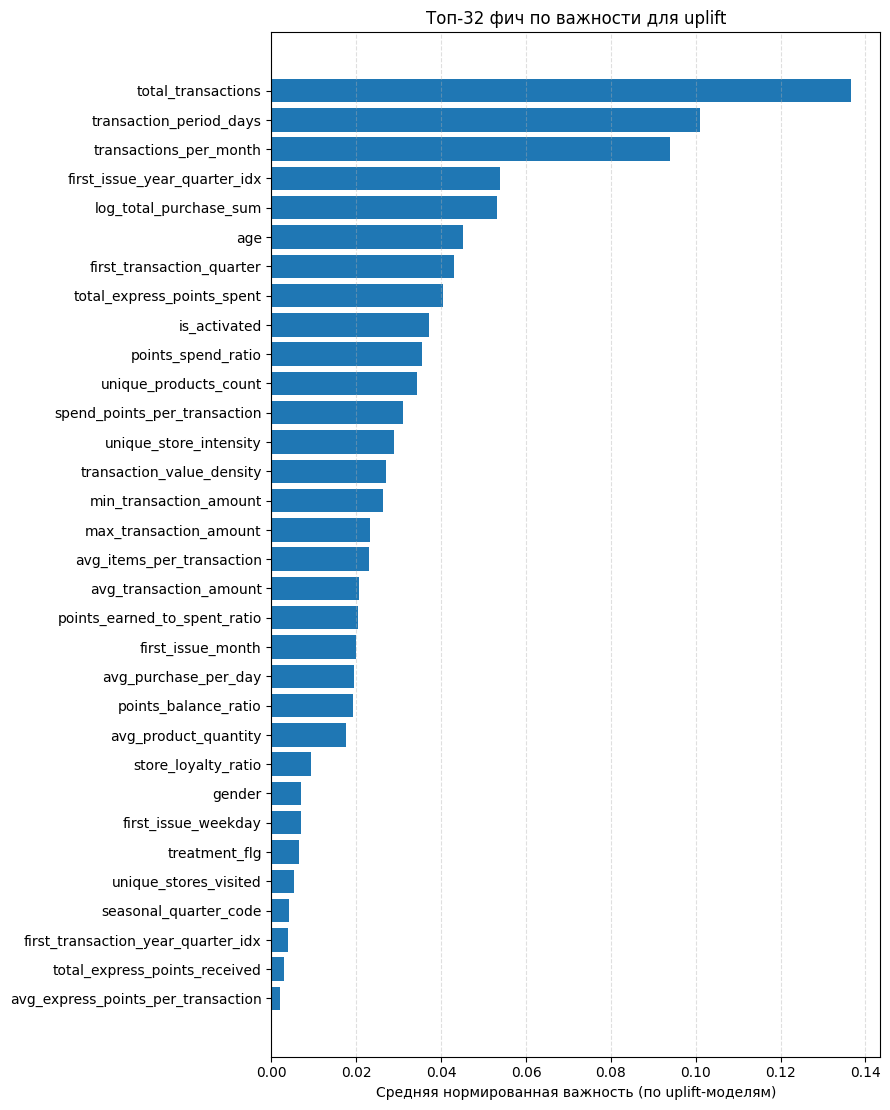

In [17]:
#  График топ-N фич по важности

TOP_N = 32
top_imp = imp_df_sorted.head(TOP_N)

plt.figure(figsize=(9, max(4, TOP_N * 0.35)))
y_pos = np.arange(len(top_imp.index))
plt.barh(y_pos, top_imp["mean_uplift_importance"].values)
plt.yticks(y_pos, top_imp.index)
plt.gca().invert_yaxis()
plt.xlabel("Средняя нормированная важность (по uplift-моделям)")
plt.title(f"Топ-{TOP_N} фич по важности для uplift")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
